In [3]:
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.data import Collector, VectorReplayBuffer
from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.trainer import offpolicy_trainer
from LCRL.utils import TensorboardLogger
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym, the constraint information is output as an element of the info dictionary in gym.step() function

"""
    Note that, we can pass arguments to the script by using
    python run_training_ddpg.py --task ra_droneracing_Game-v6 --control-net 512 512 512 512 --disturbance-net 512 512 512 512 --critic-net 512 512 512 512 --epoch 10 --total-episodes 160 --gamma 0.9
    python run_training_ddpg.py --task ra_highway_Game-v2 --control-net 512 512 512 --disturbance-net 512 512 512 --critic-net 512 512 512 --epoch 10 --total-episodes 160 --gamma 0.9
    python run_training_ddpg.py --task ra_1d_Game-v0 --control-net 32 32 --disturbance-net 4 4 --critic-net 4 4 --epoch 10 --total-episodes 160 --gamma 0.9
    
    For learning the classical reach-avoid value function (baseline):
    python run_training_ddpg.py --task ra_droneracing_Game-v6 --control-net 512 512 512 512 --disturbance-net 512 512 512 512 --critic-net 512 512 512 512 --epoch 10 --total-episodes 160 --gamma 0.9 --is-game-baseline True
    python run_training_ddpg.py --task ra_highway_Game-v2 --control-net 512 512 512 --disturbance-net 512 512 512 --critic-net 512 512 512 --epoch 10 --total-episodes 160 --gamma 0.9 --is-game-baseline True
    python run_training_ddpg.py --task ra_1d_Game-v0 --control-net 32 32 --disturbance-net 4 4 --critic-net 4 4 --epoch 10 --total-episodes 160 --gamma 0.9 --is-game-baseline True

"""

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='ra_droneracing-v6') # ra_droneracing_Game-v6, ra_highway_Game-v2, ra_1d_Game-v0
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.1)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512, 512, 512]) # for control policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512, 512, 512]) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=False) # it will be set automatically
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    parser.add_argument('--warm-start-path', type=str, default=None) # e.g., log/ra_droneracing_Game-v6/epoch_id_10/policy.pth
    args = parser.parse_known_args()[0]
    return args



args=get_args()

env = gym.make(args.task)
# check if the environment has control and disturbance actions:
assert not hasattr(env, 'action2_space'), "The environment does have disturbance actions!"
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n

args.max_action = env.action_space.high[0]

args.action1_shape = env.action1_space.shape or env.action1_space.n
args.max_action1 = env.action1_space.high[0]


train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    # report error:
    raise ValueError("Please provide critic_net!")

critic = Critic(critic_net, device=args.device).to(args.device)
critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

# import pdb; pdb.set_trace()
log_path = None

from LCRL.policy import reach_avoid_DDPGPolicy as DDPGPolicy
print("DDPG under the Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = Actor(
    actor1_net, args.action1_shape, max_action=args.max_action1, device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)

policy = DDPGPolicy(
critic,
critic_optim,
tau=args.tau,
gamma=args.gamma,
exploration_noise=GaussianNoise(sigma=args.exploration_noise),
reward_normalization=args.rew_norm,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
actor_gradient_steps=args.actor_gradient_steps,
)
log_path = os.path.join(args.logdir, args.task, 'ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.gamma)
)



# collector
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(args.buffer_size, len(train_envs)),
    exploration_noise=True
)
test_collector = Collector(policy, test_envs)

if args.warm_start_path is not None:
    policy.load_state_dict(torch.load(args.warm_start_path))
    args.kwargs = args.kwargs + "warmstarted"

epoch = 0
# writer = SummaryWriter(log_path, filename_suffix="_"+timestr+"epoch_id_{}".format(epoch))
# logger = TensorboardLogger(writer)
log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )



DDPG under the Reach-RL Bellman equation has been loaded!


In [2]:
# NOTE! if you want to use the pre-trained model, you can set the path to the model here:
# otherwise, you can skip this cell and move to the next cell
log_path = "pretrained_neural_networks/ra_droneracing_Game-v6/ddpg_reach_avoid_actor_activation_ReLU_critic_activation_ReLU_game_gd_steps_1_tau_0.005_training_num_8_buffer_size_40000_c_net_512_4_a1_512_4_a2_512_4_gamma_0.95/noise_0.1_actor_lr_0.0001_critic_lr_0.001_batch_512_step_per_epoch_40000_kwargs_{}_seed_0"


In [33]:
# data reloading module:
epoch_id = 70
envs = gym.make(args.task)
# check if the log path exists
if os.path.exists(log_path):
    policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")


policy loaded!


/tmp/ipykernel_13359/2088903253.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))


In [5]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [6]:
from LCRL.data import Batch
def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from tqdm import tqdm

  0%|          | 0/260 [00:00<?, ?it/s]/tmp/ipykernel_13359/3980174182.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 260/260 [00:20<00:00, 12.64it/s]


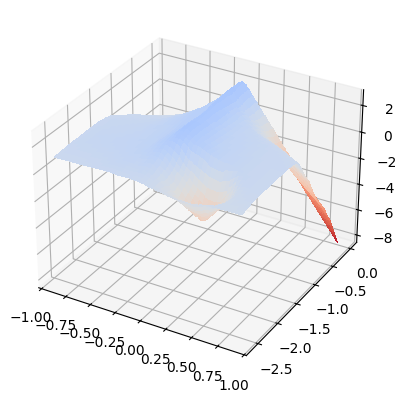

In [34]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.rcParams['font.family'] = 'Times New Roman'

x = np.arange(-0.9, 0.9, 0.01)
y = np.arange(-2.6, -0., 0.01)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))
ego_vx = 0.0
ego_vy = 0.7 # previous 0.8
ego_z = 0.0
ego_vz = 0.0


ad_x = 0.4
ad_vx = 0.0
ad_y = -2.2
ad_vy = 0.3
ad_z = 0.0
ad_vz = 0.0

X_V = X
Y_V = Y
for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            X[ii,jj], ego_vx,
            Y[ii,jj], ego_vy,
            ego_z, ego_vz,
            ad_x,  ad_vx,
            ad_y, ad_vy,
            ad_z, ad_vz
        ])
        V[ii,jj] = evaluate_V( tmp_point )
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,vmin= V.min(), vmax=-V.min(),
                        linewidth=0, antialiased=False)

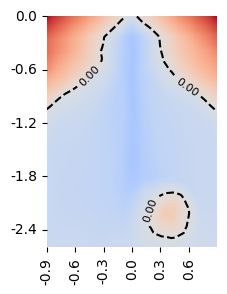

In [35]:
import seaborn as sns

x_interval = 30
y_interval = 60

fig, ax = plt.subplots(figsize=(2.2, 3))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax, vmin= V_flipped.min(), vmax=-V_flipped.min(),
            cbar=False,
            )

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+0.02, 1))

contours = ax.contour((X+0.9)*100, (Y+2.6)*100, V_flipped, levels=[0], colors="black", linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [17]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1


In [37]:
"""
success rate is computed by recording the number of initial states that can be maintained within the target set for 100 steps
"""
from LCRL.data import Batch
from tqdm import tqdm

def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

n_dim = env.observation_space.shape[0]
def roll_out_traj(env, state, horizon, verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    
    state_traj[:,0] = state
    env.reset(initial_state = state)
    safe_reaching_time = np.inf
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        action = np.array([action[0], action[1], action[2]])
        tmp, rew, _, _, info = env.step(action)
        
        state_traj[:,t+1] = tmp
        if rew > 0 and t<=horizon-2 and info["constraint"] > 0:
            if t>1 and verbose:
                print("success at time = {}!".format(t))
            return state_traj[:,:t+1], True

        if info["constraint"] < 0:
            print("constraint violated!") if verbose else None
            return state_traj[:,:t+1], False
            break
        
        if state_traj[2,t+1] > 0 or state_traj[8,t+1] > 0:
            print("A Drone passed frame!") if verbose else None
            return state_traj[:,:t+1], False
            break
    return state_traj, False

num_samples = 100
sampled_states = np.zeros((n_dim,num_samples))
num_success = 0
horizon = 300
high = np.array([  
                0.8,  0.2,  -1.5,  0.7,  0.8,  0.2,
                0.8,  0.2,  -1.5,  0.7,  0.8,  0.2,
                ], dtype=np.float32) # x1 vx1 y1 vy1 z1 vz1          x2 vx2 y2 vy2 z2 vz2
low  = np.array([  
                -0.8, -0.2, -3, 0.2, -0.8, -0.2,
                -0.8, -0.2, -3, 0.2, -0.8, -0.2,
                ], dtype=np.float32)

list_of_failure_states = []
list_of_success_states = []
list_of_sampled_states = []
for ii in tqdm(range(num_samples)):
    sampled_initial_state = np.random.uniform(low = low, high = high)
    tmp = envs.reset(initial_state = sampled_initial_state)
    sampled_states[:,ii] = tmp[0]
    while evaluate_V(sampled_states[:,ii]) < 0:
        sampled_initial_state = np.random.uniform(low = low, high = high)
        tmp = envs.reset(initial_state = sampled_initial_state)
        sampled_states[:,ii] = tmp[0]
    list_of_sampled_states.append(sampled_states[:,ii])
    traj, success = roll_out_traj(envs, sampled_states[:,ii], horizon, verbose = True)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(sampled_states[:,ii])
    else:
        list_of_failure_states.append(sampled_states[:,ii])
        continue
num_success/num_samples

 18%|█▊        | 18/100 [00:00<00:00, 165.15it/s]

success at time = 18!
success at time = 8!
success at time = 14!
success at time = 25!
success at time = 30!
success at time = 15!
success at time = 17!
success at time = 10!
success at time = 3!
success at time = 15!
success at time = 12!
success at time = 5!
success at time = 17!
success at time = 16!
success at time = 11!
success at time = 26!
success at time = 7!
success at time = 28!
success at time = 7!
success at time = 8!
success at time = 27!
success at time = 28!
success at time = 13!
success at time = 12!
constraint violated!
success at time = 16!
success at time = 11!
success at time = 11!
success at time = 10!
success at time = 10!
success at time = 22!
success at time = 11!
success at time = 10!
success at time = 11!
success at time = 8!


 60%|██████    | 60/100 [00:00<00:00, 185.90it/s]

success at time = 32!
success at time = 14!
success at time = 15!
success at time = 14!
success at time = 13!
success at time = 8!
success at time = 14!
success at time = 28!
success at time = 23!
success at time = 27!
success at time = 24!
success at time = 14!
success at time = 26!
success at time = 19!
success at time = 16!
success at time = 11!
success at time = 13!
success at time = 12!
success at time = 9!
success at time = 17!
success at time = 12!
success at time = 9!
success at time = 14!
success at time = 10!
constraint violated!
success at time = 9!
success at time = 44!
success at time = 16!
success at time = 16!
success at time = 8!


 96%|█████████▌| 96/100 [00:00<00:00, 145.49it/s]

success at time = 32!
success at time = 13!
A Drone passed frame!
success at time = 2!
success at time = 13!
success at time = 23!
constraint violated!
success at time = 22!
success at time = 25!
success at time = 27!
success at time = 17!
constraint violated!
success at time = 20!
success at time = 9!
success at time = 30!
success at time = 17!
success at time = 19!
success at time = 11!
success at time = 14!
success at time = 12!
success at time = 40!
success at time = 22!
success at time = 18!
success at time = 11!


100%|██████████| 100/100 [00:00<00:00, 159.21it/s]

success at time = 17!
success at time = 13!
success at time = 21!


0.95

success at time = 17!


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:07<00:00, 73.90it/s]
/tmp/ipykernel_13359/3000457379.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1],  colors = "#80A8D6", alpha = 0.5,
/tmp/ipykernel_13359/3000457379.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = "#80A8D6", alpha=1, label = "target set")
100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


(-0.95, 0.95)

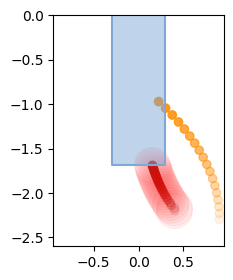

In [38]:
#9748
# note that we need to load epoch = 1600!!!!!!!!
# plot the target set too!
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib
from tqdm import tqdm
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'))
initial_state = np.array([
    0.9, ego_vx, # x, vx
    -2.3, ego_vy,
    ego_z, ego_vz,
    ad_x, ad_vx,
    ad_y, ad_vy,
    ad_z, ad_vz
])
horizon = 300
traj,_ = roll_out_traj(envs, initial_state, horizon, verbose=True)
fig, ax = plt.subplots(figsize=(2.2,3))
min_x = -0.6
max_x = 0.6
min_y = -2.8
max_y = -1.4
alphas = np.linspace(0.1, 1.0, len(traj[0,:]))
ax.scatter(traj[0,:], traj[2,:],  color = color_list[0], alpha = alphas ) #"o", color="#314cd4",  label = "ego")
ax.scatter(traj[6,:], traj[8,:],  color = color_list[4], alpha = alphas) #'o', color="#EA3323",label = "adversary")


def target_set(env, X, Y, tmp_point = np.array([
    0, 0.,-1, 0.8,-0.0, 0,0.3,  0,-2.2, 0.3,0., 0
])):
    reward = np.zeros((X.shape))
    for ii in tqdm(range(reward.shape[0])):
        for jj in range(reward.shape[1]):
            tmp_point[0], tmp_point[2] = X[ii,jj], Y[ii,jj]
            env.reset(initial_state = tmp_point)
            reward[ii,jj] = 1 if env.step([0,0,0])[1]>=0 else 0
    return reward

plt.rcParams["contour.linewidth"]=1.5

for j in tqdm(range(traj.shape[1])):    
    # plot the target set
    if j == traj.shape[1]-1:
        x = np.arange(-0.9, 0.9, 0.005)
        y = np.arange(-2.6, 0, 0.005)
        X, Y = np.meshgrid(x, y)
        reward = target_set(envs, X, Y, traj[:,j])
        plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1],  colors = "#80A8D6", alpha = 0.5, 
                    label = "target set"
                    # hatches=['//']
                    )
        plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = "#80A8D6", alpha=1, label = "target set")
    ax.add_patch(matplotlib.patches.Circle((traj[6,j], traj[8,j]), 0.2, color='r', fill=True, alpha=0.05))
ax.set_ylim([-2.6, 0])
ax.set_xlim([-0.95, 0.95])

In [32]:
policy

reach_avoid_DDPGPolicy(
  (critic): Critic(
    (preprocess): Net(
      (model): MLP(
        (model): Sequential(
          (0): Linear(in_features=15, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): ReLU()
          (4): Linear(in_features=512, out_features=512, bias=True)
          (5): ReLU()
        )
      )
    )
    (last): MLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=1, bias=True)
      )
    )
  )
  (critic_old): Critic(
    (preprocess): Net(
      (model): MLP(
        (model): Sequential(
          (0): Linear(in_features=15, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): ReLU()
          (4): Linear(in_features=512, out_features=512, bias=True)
          (5): ReLU()
        )
      )
    )
    (last): MLP(
      (model): Sequential(
        (0): Linear(in_features=